# Modelling Stall with a Vortex-Source Panel Method and Viscous Boundary Layer 
Philip Paulson

MAE 6226 Aero- and Hydrodynamics Spring 2019 Final Project

In _Lesson 11_ of _AeroPython_, we learned to use a Vortex-Source Panel Method for a symmetric airfoil. Introducing the vortex panels and **Kutta-condition** allowed us to calculate lift. What if calculated lift at varying angles of attack for the [Gemini airfoil](https://m-selig.ae.illinois.edu/ads/coord_database.html#G)?

First, let's import our standard libraries and import the airfoil data.

In [1]:
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as py
%matplotlib inline

In [2]:
filepath = os.path.join('geminism.dat')
with open(filepath, 'r') as infile:
    x, y = np.loadtxt(infile, dtype=float, unpack=True)

Luckily, the airfoil data points will work well as the panel end points and it is unneccesary to use the cosine method.

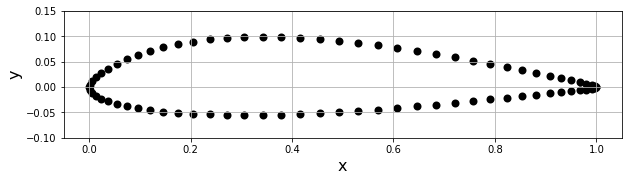

In [3]:
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.scatter(x, y, color='k', linewidth=2)
py.axis('scaled', adjustable='box')
py.xlim(-0.05, 1.05)
py.ylim(-0.1, 0.15);

## Creating Panels

In [4]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)
        
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
            
        if self.beta <= np.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
            
        self.sigma = 0.0
        self.vt = 0.0
        self.cp = 0.0

In [5]:
N = 78
panels = np.empty(N, dtype=object)
for i in range(N):
    panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])

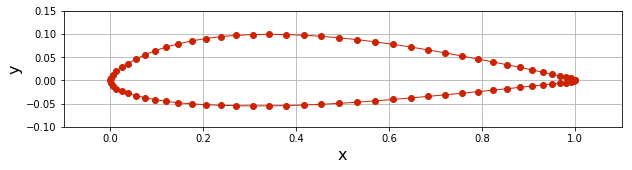

In [6]:
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.1)
py.ylim(-0.1, 0.15);

## Defining previously used classes and functions

Before getting the calculations started, we must define all the necessary functions and classes we have used in our previous assignments and lessons. 

*Note* There is a new component to the `build_rhs_vector` called un, but we will explain that part later.

In [7]:
class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)

def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 + 
                 (y - (panel.ya + np.cos(panel.beta) * s))**2))
    return integrate.quad(integrand, 0.0, panel.length)[0]

def source_contribution_normal(panels):
    A = np.empty((panels.size, panels.size), dtype=float)
    np.fill_diagonal(A, 0.5)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.cos(panel_i.beta),
                                                 np.sin(panel_i.beta))
    return A

def vortex_contribution_normal(panels):
    A = np.empty((panels.size, panels.size), dtype=float)
    np.fill_diagonal(A, 0.0)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc,
                                                  panel_j,
                                                  np.sin(panel_i.beta),
                                                  -np.cos(panel_i.beta))
    return A

def kutta_condition(A_source, B_vortex):
    b = np.empty(A_source.shape[0] + 1, dtype=float)
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    b[-1] = -np.sum(A_source[0,:] + A_source[-1,:])
    return b

def build_singularity_matrix(A_source, B_vortex):
    A = np.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype = float)
    A[:-1, :-1] = A_source
    A[:-1, -1] = np.sum(B_vortex, axis=1)
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

def build_rhs_vector(panels, freestream, un=0.0):
    b = np.empty(panels.size + 1, dtype=float)
    b[:-1] += un
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta))
    return b

def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = np.empty((panels.size, panels.size + 1), dtype=float)
    A[:, :-1] = B_vortex
    A[:, -1] = -np.sum(A_source, axis=1)
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta
                                   for panel in panels])
    strengths = np.append([panel.sigma for panel in panels], gamma)
    tangential_velocities = np.dot(A, strengths) + b
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2


### We can build the A matrix first because the varying angle of attack will only affect the b array

In [8]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(A_source, B_vortex)

## Solving for Lift

Here, we will define our angles of attack and initial conditions. We will then define functions to solve the coefficient of lift for the airfoil at each angle of attack. Since the wind tunnel testing from our experimental data was done at a Reynolds number of 300,000, the freestream velocity is based on this number and atmospheric conditions.

The graph below compares the [experimental data](https://m-selig.ae.illinois.edu/uiuc_lsat/Low-Speed-Airfoil-Data-V1.pdf) with our calculations.

In [9]:
N_alpha = 10
alpha = np.linspace(-6.0, 12.0, N_alpha)
p_inf = 101325.0 #Pascals
rho = 1.225 #kg/m^3
Re = 300000.0
chord = x.max() - x.min()
mu = 1.5 * 10**(-5) #Ns/m^2
u_inf = mu * Re / (rho * chord)

In [10]:
def Lift(N, panels, freestream, p_inf, rho):
    p = np.empty(N, dtype=float)
    beta = np.empty(N, dtype=float)
    length =np.empty(N, dtype=float)
    for j in range(N):
        p[j] = p_inf + ((1/2) *  panels[j].cp * rho * freestream.u_inf**2)
        beta[j] = panels[j].beta
        length[j] = panels[j].length
    
    Lift = -np.sum(p * np.sin(beta)* length)
    return Lift

In [11]:
def CL_varying_angles(N_alpha, N, u_inf, alpha, panels, A, A_source, B_vortex, p_inf, rho, chord, un):
    L = np.empty(N_alpha, dtype=float)
    cp = np.empty((N, N_alpha), dtype=float)
    ut = np.empty((N, N_alpha), dtype=float)
    for i in range(N_alpha):
        freestream = Freestream(u_inf, alpha[i])
        b = build_rhs_vector(panels, freestream, un=un)
        strengths = np.linalg.solve(A, b)
        for k, panel in enumerate(panels):
            panel.sigma = strengths[k]
        gamma = strengths[-1]
        compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
        compute_pressure_coefficient(panels, freestream)
        for n, panel in enumerate(panels):
            cp[n,i] = panel.cp
            ut[n,i] = panel.vt
        L[i] = Lift(N, panels, freestream, p_inf, rho)
    C_L = L / (0.5 * rho * u_inf**2 * chord)
    return C_L, cp, ut

In [12]:
C_L, cp, ut = CL_varying_angles(N_alpha, N, u_inf, alpha, panels, A, A_source, B_vortex, p_inf, rho, chord, un=0.0)

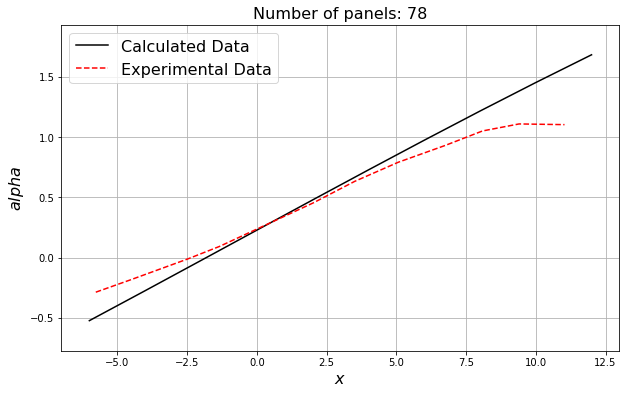

In [13]:
filepathe = os.path.join('gemini_experimental.csv')
with open(filepathe, 'r') as infile:
    Alpha_exp, CL_exp = np.loadtxt(infile, dtype=float, delimiter=',', unpack=True)

py.figure(figsize=(10,6))
py.grid()
py.xlabel('$x$', fontsize=16)
py.ylabel('$alpha$', fontsize=16)
py.plot(alpha, C_L, label='Calculated Data', color='k', linestyle='-')
py.plot(Alpha_exp, CL_exp, label='Experimental Data', color='r', linestyle='--')
py.title('Number of panels: {}'.format(panels.size), fontsize=16)
py.legend(loc='best',prop={'size':16})
py.xlim(alpha[0]-1.0,alpha[9]+1.0)
py.ylim(C_L[0]-0.25, C_L[9]+0.25);

### What's wrong with the Calculated Data?

Remember, the panel method assumes an inviscid flow which causes a violation of the no slip condition (Remember solving for the tangential velocity at the surface of the panels). The inviscid calculation is a good start. We can use the data calculated to compute the boundary layer of the airfoil and compute the new lift with the boundary layer included.

## Boundary Layer Calculation

To approximate the boundary layer on the airfoil, we can calculate the normal velocity at the edge of the boundary layer. Since the boundary layer is very thin, we can add the normal velocity to right hand side of the panel method solver to take into account the effect of the boundary layer. We will first calculate a fully laminar boundary layer using the thwaites method derived in class.

In [14]:
def solve_panel_method(panels, A_source, B_source, freestream, un=0.0):
    # Assemble the system.
    A = build_singularity_matrix(A_source, B_source)
    b = build_rhs_vector(panels, freestream, un=un)
    
    # Solve the system for the singularity strengths.
    strengths = np.linalg.solve(A, b)

    # Store the source-sheet strengths and the vortex-sheet strength.
    sigmas = strengths[:-1]
    gamma = strengths[-1]
    
    # Compute the tangential velocity component on the panels.
    bt =  freestream.u_inf * np.sin([freestream.alpha - p.beta for p in panels])
    ut = bt + np.dot(B_source, sigmas) - np.sum(A_source, axis=1) * gamma
    
    # Compute the pressure coefficient on the panels.
    cp = 1 - (ut / freestream.u_inf)**2
    
    return ut, cp

In [15]:
def running_coordinates(panels):
    ds = [0.0, 0.5 * panels[0].length]
    for i in range(len(panels) - 1):
        ds.append(0.5 * (panels[i].length + panels[i + 1].length))
    s = np.cumsum(ds)
    return s

In [16]:
def momentum_thickness(s, Ue, rho, mu):
    theta = np.empty_like(Ue)
    dUeds = np.gradient(Ue, s)
    theta[0] = np.sqrt(0.075 * mu / (rho * dUeds[0]))
    coeff = theta[0]**2 * Ue[0]**6
    for i in range(1, s.size):
        var = (coeff + 0.45 * mu / rho *
               np.trapz(Ue[:i + 1]**5, s[:i + 1]))
        theta[i] = np.sqrt(var / Ue[i]**6)
    return theta

def lambda_parameter(s, Ue, theta, rho, mu):
    dUeds = np.gradient(Ue, s)
    lamb = rho / mu * theta**2 * dUeds
    return lamb

def l_parameter(lamb):
    if lamb > 0.0:
        return 0.22 + 1.57 * lamb - 1.8 * lamb**2
    return 0.22 + 1.402 * lamb + 0.018 * lamb / (lamb + 0.107)

def shape_factor(lamb):
    if lamb > 0.0:
        return 2.61 - 3.75 * lamb + 5.24 * lamb**2
    return 2.088 + 0.0731 / (lamb + 0.14)

l_parameter_vec = np.vectorize(l_parameter)
shape_factor_vec = np.vectorize(shape_factor)

def skin_friction_coefficient(Ue, theta, lamb, rho, mu):
    Re_theta = rho * Ue * theta / mu
    cf = 2 * l_parameter_vec(lamb) / Re_theta
    return cf

def thwaites(s, Ue, rho, mu):
    theta = momentum_thickness(s, Ue, rho, mu)
    lamb = lambda_parameter(s, Ue, theta, rho, mu)
    H = shape_factor_vec(lamb)
    cf = skin_friction_coefficient(Ue, theta, lamb, rho, mu)
    return theta, H, cf

In [17]:
panelsb = np.empty(N, dtype=object)
for i in range(N):
    panelsb[i] = Panel(x[i], y[i], x[i+1], y[i+1])
freestream = Freestream(u_inf, 4.0)
uti, cpi = solve_panel_method(panels, A_source, B_vortex, freestream, 0.0)

In [18]:
utvis = np.empty((N,N_alpha), dtype=float)
cpvis = np.empty((N,N_alpha), dtype=float)
C_L_vis = np.empty(N_alpha, dtype=float)
for i in range(N_alpha):
    freestream = Freestream(u_inf, alpha[i])
    uti, cpi = solve_panel_method(panels, A_source, B_vortex, freestream, 0.0)
    idx = np.where(uti >= 0.0)[0][0]
    x_stagn, y_stagn = panels[idx].xa, panels[idx].ya
    upper = panels[idx - 1::-1]
    lower = panels[idx:]
    s_upper = running_coordinates(upper)
    s_lower = running_coordinates(lower)
    Ue_upper = np.empty(len(upper) + 1)
    Ue_upper[0] = 1e-6
    Ue_upper[1:] = -uti[idx - 1::-1]
    Ue_lower = np.empty(len(lower) + 1)
    Ue_lower[0] = 1e-6
    Ue_lower[1:] = uti[idx:]
    theta, H, cf = thwaites(s_upper, Ue_upper, rho, mu)
    delta = theta * H  # displacement thickness
    un_upper = np.gradient(Ue_upper * delta, s_upper)
    theta, H, cf = thwaites(s_lower, Ue_lower, rho, mu)
    delta = theta * H  # displacement thickness
    un_lower = np.gradient(Ue_lower * delta, s_lower)
    un = np.concatenate((un_upper[:0:-1], un_lower[1:]))
    utvis[:,i], cpvis[:,i] = solve_panel_method(panels, A_source, B_vortex, freestream, un=un)
    p = p_inf + 0.25 * cpvis[:,i] * rho * freestream.u_inf**2
    beta = np.empty(N, dtype=float)
    length =np.empty(N, dtype=float)
    for j in range(N):
        beta[j] = panels[j].beta
        length[j] = panels[j].length
    Lift = -np.sum(p * np.sin(beta)* length)
    C_L_vis[i] = Lift / (0.5 * rho * u_inf**2 * chord)

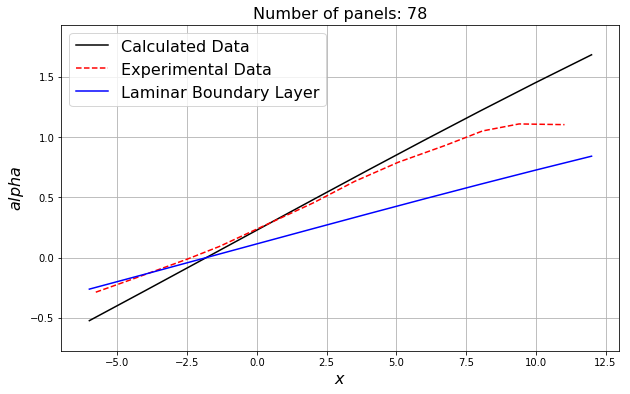

In [19]:
py.figure(figsize=(10,6))
py.grid()
py.xlabel('$x$', fontsize=16)
py.ylabel('$alpha$', fontsize=16)
py.plot(alpha, C_L, label='Calculated Data', color='k', linestyle='-')
py.plot(Alpha_exp, CL_exp, label='Experimental Data', color='r', linestyle='--')
py.plot(alpha, C_L_vis, label='Laminar Boundary Layer', color='b', linestyle='-')
py.title('Number of panels: {}'.format(panels.size), fontsize=16)
py.legend(loc='best',prop={'size':16})
py.xlim(alpha[0]-1.0,alpha[9]+1.0)
py.ylim(C_L[0]-0.25, C_L[9]+0.25);

### Error in Laminar Boundary Layer Approximation

As seen above, the fully laminar boundary layer approximation also does not give us the correct results because the boundary layer transitions to turbulent flow along the airfoil. The flow also begins to separate at steep angles of attack. Viscous results from XFLR5 are imported and plotted below. These simulations match the experimental data much better.

## Turbulent Boundary Layer 

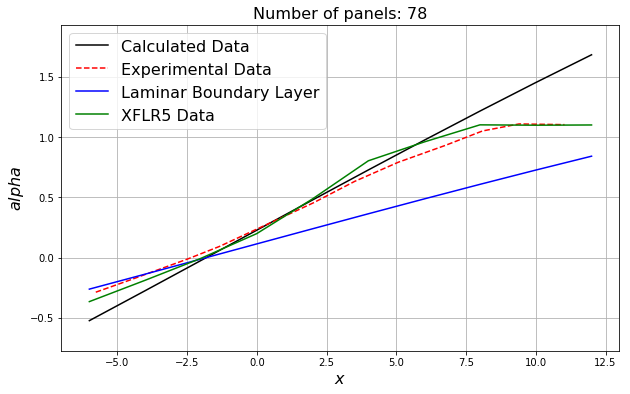

In [20]:
filepathx = os.path.join('xflr5_cl.csv')
with open(filepathx, 'r') as infile:
    Alphax, CL_x = np.loadtxt(infile, dtype=float, delimiter=',', unpack=True)

py.figure(figsize=(10,6))
py.grid()
py.xlabel('$x$', fontsize=16)
py.ylabel('$alpha$', fontsize=16)
py.plot(alpha, C_L, label='Calculated Data', color='k', linestyle='-')
py.plot(Alpha_exp, CL_exp, label='Experimental Data', color='r', linestyle='--')
py.plot(alpha, C_L_vis, label='Laminar Boundary Layer', color='b', linestyle='-')
py.plot(alpha, CL_x, label = 'XFLR5 Data', color='g', linestyle='-')
py.title('Number of panels: {}'.format(panels.size), fontsize=16)
py.legend(loc='best',prop={'size':16})
py.xlim(alpha[0]-1.0,alpha[9]+1.0)
py.ylim(C_L[0]-0.25, C_L[9]+0.25);

The boundary layer thickness and normal velocity component for the turbulent boundary layer can be approximated using Head's Method. I was not able to implement this method, but the code below  is the beginning of the of this method. In order to find the transition point from laminar to turbulent, the Michel's criterion can be used.

<center><img src="HeadsMethod.PNG"></center>
### <center> Head's Method for Turbulent Boundary Layer Approximation



<center><img src="michels_criterion.PNG"></center>
### <center> Michel's Criterion

In [31]:
freestream = Freestream(u_inf, 0.0)
ut, cp = solve_panel_method(panels, A_source, B_vortex, freestream, 0.0)
idx = np.where(uti >= 0.0)[0][0]
x_stagn, y_stagn = panels[idx].xa, panels[idx].ya
upper = panels[idx - 1::-1]
lower = panels[idx:]
s_upper = running_coordinates(upper)
s_lower = running_coordinates(lower)
cp_upper = cp[idx - 1::-1]
cp_lower = cp[idx:]
Ue_upper = np.empty(len(upper) + 1)
Ue_upper[0] = 1e-6
Ue_upper[1:] = -uti[idx - 1::-1]
Ue_lower = np.empty(len(lower) + 1)
Ue_lower[0] = 1e-6
Ue_lower[1:] = uti[idx:]
thetau, Hu, cfu = thwaites(s_upper, Ue_upper, rho, mu)
deltau = thetau * Hu  # displacement thickness
thetal, Hl, cfl = thwaites(s_lower, Ue_lower, rho, mu)
deltal = thetal * Hl  # displacement thickness
#Find local Reynolds numbers

Re_thu = thetau[1:] * Ue_upper[1:] * rho / mu
Re_xu = s_upper[1:] * Ue_upper[1:] * rho / mu

Re_thl = thetal[1:] * Ue_lower[1:] * rho / mu
Re_xl = s_lower[1:] * Ue_lower[1:] * rho / mu

for i in range(len(Re_thu)):
    Michel = 1.174 * (1.0 + (22400 / Re_xu[i])) * Re_xu[i]**0.46
    if Re_thu[i] >= Michel:
        idx_turbu = i
        break

for i in range(len(Re_thl)):
    Michel = 1.174 * (1.0 + (22400 / Re_xl[i])) * Re_xl[i]**0.46
    if Re_thl[i] >= Michel:
        idx_turbl = i
        break
un_upper_lam = np.gradient(Ue_upper[:idx_turbu] * delta[:idx_turbu], s_upper[:idx_turbu])
un_lower_lam = np.gradient(Ue_lower[:idx_turbl] * delta[:idx_turbl], s_lower[:idx_turbl])



# References

http://by.genie.uottawa.ca/~mcg4345/AdditionalNotes/51_BLTransition.pdf

http://by.genie.uottawa.ca/~mcg4345/AdditionalNotes/52_HeadsMethod.pdf

https://www.seas.upenn.edu/~dhawkes/viscous-panel-method/

https://m-selig.ae.illinois.edu/uiuc_lsat/Low-Speed-Airfoil-Data-V1.pdf

Moran, J., An introduction to theoretical and computational aerodynamics, New York: Wiley, 1984. 